In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Gaussian Mixture Models

## (1-dim) Gaussian distribution

In [2]:
# draw points from two normal distributions
values1 = np.random.normal(loc=-10, scale=10, size=10000)
values2 = np.random.normal(loc=2, scale=1, size=10000)

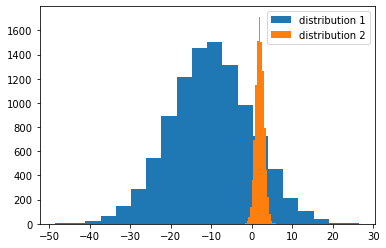

In [3]:
# plot histograms
plt.hist(values1,bins=20,label='distribution 1')
plt.hist(values2,bins=20,label='distribution 2')
plt.legend()
plt.show()

## Multivariate (2-dim) Gaussian distribution

In [4]:
def covariance_matrix(direction,evalues):
    'builds a 2x2 covariance matrix'
    
    # first vector
    q1 = np.array(direction)
    q1 = q1/np.linalg.norm(q1) # normalize
    
    # second vector (perpendicular to q1)
    q2 = np.array([-q1[1],q1[0]])
    q2 = q2/np.linalg.norm(q2) # normalize
    
    # orthogonal matrix Q
    Q = np.zeros((2,2))
    Q[:,0] = q1
    Q[:,1] = q2
    
    # diagonal matrix
    D = np.diag(evalues)
    
    return Q.dot(D.dot(Q.T))

In [5]:
cov1 = covariance_matrix(direction=[2,1],evalues=[10,1])
cov1

array([[8.2, 3.6],
       [3.6, 2.8]])

In [6]:
cov2 = covariance_matrix(direction=[1,0],evalues=[1,1])
cov2

array([[1., 0.],
       [0., 1.]])

In [7]:
mean1 = np.array([5,5])
mean2 = np.array([0,0])

In [8]:
X1 = np.random.multivariate_normal(mean = mean1, cov = cov1, size = 1000)
X2 = np.random.multivariate_normal(mean = mean2, cov = cov2, size = 1000)

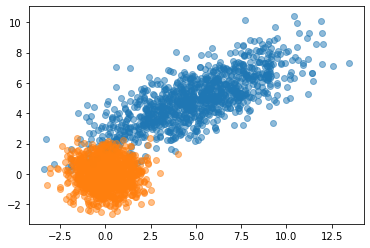

In [9]:
plt.scatter(X1[:,0],X1[:,1],label='distribution 1',alpha=0.5)
plt.scatter(X2[:,0],X2[:,1],label='distribution 2',alpha=0.5)

In [10]:
mean1,mean2

(array([5, 5]), array([0, 0]))

In [11]:
# maximum likelihood estimation
np.mean(X1,axis=0), np.mean(X2,axis=0)

(array([4.96524304, 4.92846696]), array([-0.00373143, -0.01659954]))

In [12]:
cov1, cov2

(array([[8.2, 3.6],
        [3.6, 2.8]]),
 array([[1., 0.],
        [0., 1.]]))

In [13]:
# maximum likelihood estimation
np.cov(X1,rowvar=False), np.cov(X2,rowvar=False)

(array([[7.83367291, 3.51411031],
        [3.51411031, 2.82384329]]),
 array([[ 1.00813079, -0.01767987],
        [-0.01767987,  0.8956069 ]]))

## Gaussian mixtures

In [14]:
# Gaussian dist. probabilities
pi = [0.05,0.25,0.7]
# means
mean = [[10,5],[0,0],[-10,-10]]
#  covariance matrices
cov1 = covariance_matrix(direction=[2,1],evalues=[10,1])
cov2 = covariance_matrix(direction=[0,1],evalues=[2,2])
cov3 = covariance_matrix(direction=[1,1],evalues=[2,20])
cov = [cov1, cov2, cov3]

In [15]:
# sample m points from the Gaussian mixture (k=3)
m = 1000
k = 3 
dist = np.random.choice(k,m,p=pi)
X = np.zeros((m,2))
for i in range(k):
    # number of points from dist. i
    ni = np.sum(dist==i)
    X[dist==i] = np.random.multivariate_normal(mean = mean[i], cov = cov[i], size=ni)

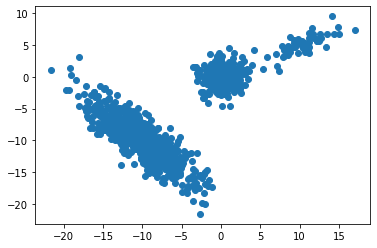

In [16]:
plt.scatter(X[:,0],X[:,1])